In [1]:
!pip install torch torchvision opencv-python numpy matplotlib scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [28]:
# Paths to dataset
base_dir = "/content/drive/MyDrive/Dataset"
normal_dir = os.path.join(base_dir, "Normal")
potholes_dir = os.path.join(base_dir, "Potholes")

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Create train and validation generators
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Compute class weights for handling imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


Found 546 images belonging to 3 classes.
Found 135 images belonging to 3 classes.


In [29]:
# Load ResNet50 with pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze most layers and unfreeze the top 10 layers for fine-tuning
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 4,728,065 (18.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [30]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5080 - loss: -1.3624 - val_accuracy: 0.5185 - val_loss: -3.0799 - learning_rate: 1.0000e-04
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 779ms/step - accuracy: 0.5347 - loss: -5.1732 - val_accuracy: 0.5185 - val_loss: -7.2382 - learning_rate: 1.0000e-04
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 793ms/step - accuracy: 0.5404 - loss: -9.0925 - val_accuracy: 0.5185 - val_loss: -15.2244 - learning_rate: 1.0000e-04
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 729ms/step - accuracy: 0.5311 - loss: -14.7411 - val_accuracy: 0.5185 - val_loss: -38.8712 - learning_rate: 1.0000e-04
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 663ms/step - accuracy: 0.5199 - loss: -22.0281 - val_accuracy: 0.5185 - val_loss: -84.4123 - learning_rate: 1.0000e-04
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 705ms/step - accuracy: 0.5070 - loss: -32.6144 - val_accuracy: 0.5185 - val_loss: -119.9499 - learning_rate: 1.0000e-04
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 817ms/step

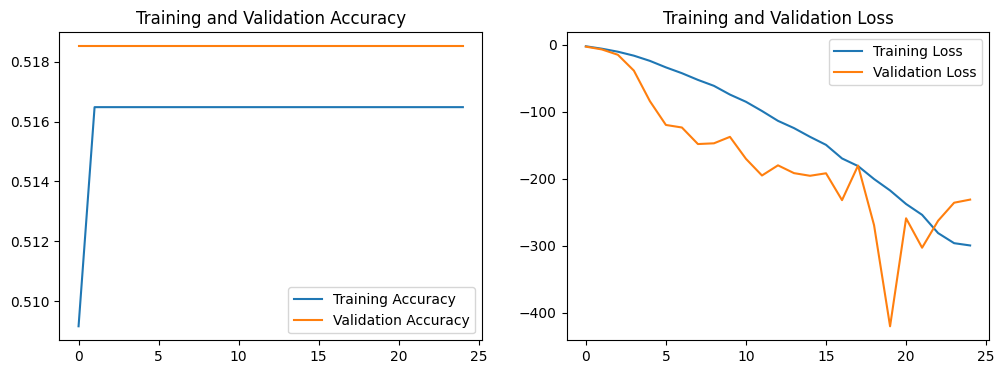

In [31]:
# Plot training and validation metrics
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)

In [32]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 860ms/step - accuracy: 0.4923 - loss: -445.0276
Validation Accuracy: 51.85%


In [33]:
# Predict and evaluate performance
val_generator.reset()
predictions = model.predict(val_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()
true_labels = val_generator.classes

# Classification report and confusion matrix
print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Potholes']))
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
              precision    recall  f1-score   support

      Normal       0.52      1.00      0.68        70
    Potholes       0.00      0.00      0.00        65

    accuracy                           0.52       135
   macro avg       0.26      0.50      0.34       135
weighted avg       0.27      0.52      0.35       135

Confusion Matrix:
 [[70  0]
 [65  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
# Save the trained model
model.save('/content/drive/MyDrive/pothole_detection_model.h5')
print("Model saved to Google Drive.")


Model saved to Google Drive.


Saving images.jpg to images.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


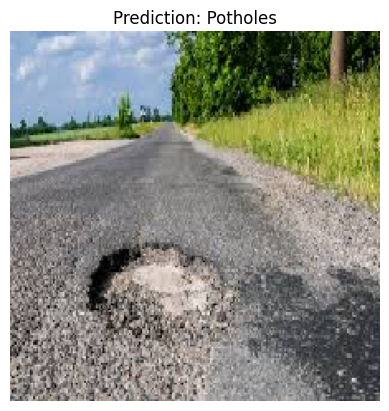

In [37]:
# predicting images
from google.colab import files
from tensorflow.keras.preprocessing import image

def upload_and_predict(model):
    uploaded = files.upload()
    for img_path in uploaded.keys():
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict the class
        prediction = model.predict(img_array)
        result = "Potholes" if prediction > 0.5 else "Normal"

        # Display the image and prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {result}")
        plt.show()

upload_and_predict(model)